## Import Library

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from keras import optimizers
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

## Preprocessing Data

In [2]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_generator=train_datagen.flow_from_directory('Dataset', target_size=(128,128), color_mode='rgb', batch_size=30, shuffle='True', subset='training')
validation_generator=train_datagen.flow_from_directory('Dataset', batch_size=64, shuffle=False, target_size=(128,128), subset='validation')

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## Create The Model

In [3]:
# Load the ResNet50V2
baseModel=ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(128,128,3)))

# Construct the new head of the model
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(4,4))(headModel) # input layer
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(64, activation="relu")(headModel) # hidden layer
headModel=Dropout(0.5)(headModel)
headModel=Dense(2, activation="softmax")(headModel) # output layer

# place the new head model on top of the base model
model=Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model
for layer in baseModel.layers:
    layer.trainable=False

In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 23,696,066 (90.39 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

## Training The Model

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98):
            self.model.stop_training=True

stopTraining=Callback()

In [10]:
history=model.fit(train_generator, validation_data=validation_generator, epochs=15, callbacks=[stopTraining])

c:\Users\LENOVO\Desktop\Portfolio_AI\P33\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


c:\Users\LENOVO\Desktop\Portfolio_AI\P33\venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8094 - loss: 0.5480 - val_accuracy: 0.9100 - val_loss: 0.2368
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9127 - loss: 0.2259 - val_accuracy: 0.8967 - val_loss: 0.2552
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9246 - loss: 0.1956 - val_accuracy: 0.9267 - val_loss: 0.1899
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9422 - loss: 0.1555 - val_accuracy: 0.9367 - val_loss: 0.2063
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9488 - loss: 0.1326 - val_accuracy: 0.9267 - val_loss: 0.2017
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9496 - loss: 0.1303 - val_accuracy: 0.9333 - val_loss: 0.1987
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9527 - loss: 0.1164 - val_accuracy: 0.9333 - val_loss: 0.2081
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9566 - loss: 0.1061 - val_accuracy: 0.9333 - val_loss: 0.

## Evaluasi

In [14]:
predicts_vectors=model.predict(validation_generator, verbose=1)

c:\Users\LENOVO\Desktop\Portfolio_AI\P33\venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [15]:
pred=np.argmax(predicts_vectors, axis=1)

In [16]:
lb=LabelBinarizer()
lb.fit(validation_generator.labels)

y_test=lb.transform(validation_generator.labels)
y_pred=lb.transform(pred)

In [17]:
y_true=validation_generator.labels
y_pred=pred

recall=recall_score(y_true, y_pred, average='macro')
precision=precision_score(y_true, y_pred, average='macro')
f1=f1_score(y_true, y_pred, average='macro')
acc=accuracy_score(validation_generator.labels, pred)

In [18]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [19]:
print(y_pred)

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1]


In [20]:
print('>>>> Result <<<<')
print('Accuracy: {}'.format(acc*100))
print('Recall: {}'.format(recall*100))
print('Precision: {}'.format(precision*100))
print('F1-Score: {}'.format(f1))

>>>> Result <<<<
Accuracy: 92.0
Recall: 92.0
Precision: 92.0074679943101
F1-Score: 0.9199964442864128


In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       150
           1       0.93      0.91      0.92       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



In [22]:
def get_confusion_matrix(y_true, y_pred):
    n_classes=len(np.unique(y_true))
    conf=np.zeros((n_classes, n_classes))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [23]:
conf=get_confusion_matrix(y_test, y_pred)
conf

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11472\2394499196.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf[int(actual)][int(pred)] += 1


array([[139,  11],
       [ 13, 137]])

Text(0.5, 23.52222222222222, 'Predicted Label')

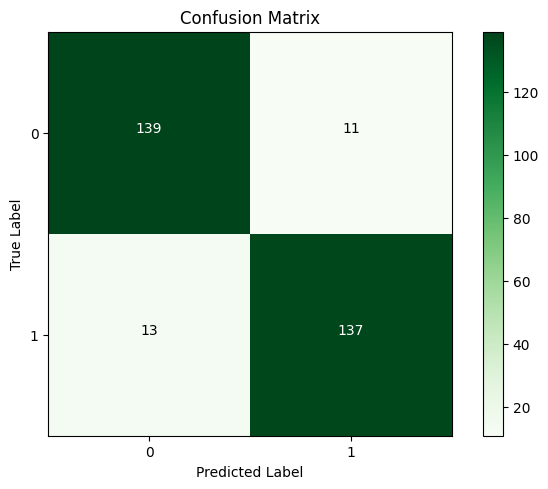

In [25]:
classes=[0, 1]

# Plot Confusion Matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks=np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt='d'
thresh=conf.max()/2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')